# Cryogenic Pump Data Analysis v2 Cleaning
### Jared Nielsen

In [108]:
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sys

plt.rcParams['figure.figsize'] = 15,3
blue = '#1f77b4'
pd.set_option('precision', 2)

## Loading Data
The `client.csv` files are 1.8GB (14 million rows x 38 cols), 1.2GB, and a few hundred KB, respectively.  
For comparison, `QSS Data Share.csv` is 200MB. Pandas crashes when I load the files, so we might need a better system.  
A 100k-row CSV takes 1.2 seconds, a 1-million row CSV takes 12 seconds to load, and it appears to scale linearly.  
An out-of-memory error is thrown when loading a 14-million row CSV.

In [79]:
# CSVs to load. For simplicity, we will just work with the first one initially. It's plenty big.
filenames = [
    '20180814_102020_DMOS6_0_client.csv',
    '20180814_102020_DMOS6_0_unit.csv',
    '20181105_130901_DMOS6_0_client.csv',
    '20181105_130901_DMOS6_0_unit.csv',
    '20181105_131740_DMOS6_0_client.csv',
    '20181105_131740_DMOS6_0_unit.csv'
]
folder = '/mnt/pccfs/backed_up/tcs/Archive/'
url_client = folder+filenames[0]
url_unit = folder+filenames[1]

# Load the key, which maps pump IDs to their type.
x_unit = pd.read_csv(url)

# Declare datatypes (strings/floats) for each field in the CSV.
dtype = {
    "unitsequence": int, # ID, negative is test, positive is production
    "uppervalue": float, # turbo vibrations
    "lowervalue": float,
    "rotorspeed": float, # turbo speed
    "motortemp": float, # turbo
    "controllertemp": float, # turbo
    "dcvoltage": float, # turbo
    "motorcurrent": float, # turbo
    "rotorposition0": str, # turbo, positions of the sensors that determine vibration
    "rotorposition1": str,
    "rotorposition2": str,
    "rotorposition3": str,
    "rotorposition4": str,
    "magcurrent0": float, # turbo balancing factors
    "magcurrent1": float, # 0-7 should all be symmetrical
    "magcurrent2": float,
    "magcurrent3": float,
    "magcurrent4": float,
    "magcurrent5": float,
    "magcurrent6": float,
    "magcurrent7": float,
    "magcurrent8": float, # last two are on top
    "magcurrent9": float,
    "sumcurrents": float, # sum of them
    "tmsactualtemp": float, # turbo heating system temperature. -80 means "NaN"
    "yh": str, # Alcatel turbo, replacement for `rotorposition0`.
    "yb": str,
    "z": float,
    # CRYO fields
    "motorspeed": str, # cryos
    "temp1": float, # cryos, target 65
    "temp2": float, # cryos, target 9/11
    "heater1": float,
    "heater2": float,
    "tcpressure": float, # thermocouple gauge pressure, cryo
    "timestamp": str,
    "currentregen": str, # letter codes
    "alarmstatusbits": str, # 
    "alertstatusbits": str,
    "valvestate": str
}
parse_dates = ['timestamp']
start = datetime.now()
x_client = pd.read_csv(url, dtype=dtype, parse_dates=parse_dates, nrows=1000000)
x_client.loc[:,'timestamp'] = x_client.loc[:,'timestamp'].astype('datetime64[m]')
print("Shape:", x_client.shape)
elapsed = (datetime.now() - start).total_seconds()
print("Time: {:.3f}".format(elapsed))

Shape: (1000000, 38)
Time: 12.176


## Cleaning Data
We've already subsampled from milliseconds up to minutes.  
Now keep only one sample per minute per pump.  
Merge the `unitsequence` with the `dsname`, or pump type.  
Separate into cryos and turbos, and keep only the relevant fields.  
Remove duplicate minutes on the same pump (there's too much data here; one sample per minute is plenty).  
### Questions
What does `currentregen` refer to? It takes values `P` and `V`.  
Are the `magcurrents` worth including in the turbo?  
### Theories
`heater1` and `heater2` takes binary values, indicating on/off.

In [81]:
# TODO: Possibly include rotorspeed in the cryo. It's present in some but not all.
cryo_cols = ['unitsequence', 'timestamp', 'temp1', 'temp2', 
             'heater1', 'heater2', 'tcpressure', 'currentregen']
cryo_vals = ['temp1', 'temp2', 'heater1', 'heater2', 'tcpressure']
# TODO: Possibly include the magcurrents in the turbo.
turbo_cols = ['unitsequence', 'timestamp', 'uppervalue', 'lowervalue', 'rotorspeed', 
              'controllertemp', 'dcvoltage', 'motorcurrent']
turbo_vals = turbo_cols[2:]


def clean(x_unit, x_client):
    x_client_deduplicate = x_client.drop_duplicates(subset=['unitsequence', 'timestamp'], keep='first')
    x_merge = pd.merge(x_client_deduplicate, x_unit, on='unitsequence')
    x_cryo = x_merge[x_merge['dsname'] == 'CRYO'][cryo_cols]
    x_turbo = x_merge[x_merge['dsname'] == 'SCU'][turbo_cols]
    
    return x_cryo, x_turbo
    
x_cryo, x_turbo = clean(x_unit, x_client)

## Cleaned Cryo Data

In [83]:
print("x_cryo: {}".format(x_cryo.shape))
print("dtypes: {}".format(x_cryo.dtypes))
x_cryo.head(5)

x_cryo: (140234, 8)
dtypes: unitsequence             int64
timestamp       datetime64[ns]
temp1                  float64
temp2                  float64
heater1                float64
heater2                float64
tcpressure             float64
currentregen            object
dtype: object


,unitsequence,timestamp,temp1,temp2,heater1,heater2,tcpressure,currentregen
2824,17798282,2018-04-10 14:57:00,65.0,12.2,1.0,0.0,0.5,P
2825,17798282,2018-04-10 14:58:00,65.0,12.1,1.0,0.0,0.5,P
2826,17798282,2018-04-10 14:59:00,65.0,12.2,1.0,0.0,0.5,P
2827,17798282,2018-04-10 15:00:00,64.9,12.2,1.0,0.0,0.5,P
2828,17798282,2018-04-10 15:01:00,64.9,12.1,1.0,0.0,0.5,P


## Cleaned Turbo Data

In [96]:
print("x_turbo: {}".format(x_turbo.shape))
print("dtypes: {}".format(x_turbo.dtypes))
x_turbo.head(5)

x_turbo: (28510, 8)
dtypes: unitsequence               int64
timestamp         datetime64[ns]
uppervalue               float64
lowervalue               float64
rotorspeed               float64
controllertemp           float64
dcvoltage                float64
motorcurrent             float64
dtype: object


,unitsequence,timestamp,uppervalue,lowervalue,rotorspeed,controllertemp,dcvoltage,motorcurrent
0,16775261,2018-04-10 14:57:00,2.0,13.0,545.0,147.0,122.0,0.4
1,16775261,2018-04-10 14:58:00,2.0,13.0,545.0,147.0,122.0,0.5
2,16775261,2018-04-10 14:59:00,2.0,13.0,545.0,147.0,122.0,0.5
3,16775261,2018-04-10 15:00:00,2.0,13.0,545.0,147.0,122.0,0.5
4,16775261,2018-04-10 15:01:00,2.0,13.0,545.0,147.0,122.0,0.5


## Pump Grouping, Interval Segmentation

In [103]:
def get_unitsequences(x_subset):
    return x_subset['unitsequence'].unique()

def get_pump(x_subset, unitsequence):
    return x_subset[x_subset['unitsequence'] == unitsequence]

def get_intervals(x_pump):
    """
    Parameters:
        x_pump (DataFrame): output of get_pump().
    Returns:
        intervals (list(DataFrame)): the DataFrame intervals, ordered by time.
    """
    x_pump_sorted = x_pump.sort_values("timestamp").copy()
    interval_desc = (x_pump_sorted["timestamp"].diff() > pd.Timedelta(minutes=30)).cumsum()
    intervals = [v for k,v in x_pump_sorted.groupby(interval_desc)]
    return intervals

def plot_interval(interval, val_names, title=None):
    interval.plot(x='timestamp', y=val_names,
                subplots=True, layout=(2,2), marker='o', linestyle='None', color=blue,
                markersize=3, figsize=(20,10))
    if title:
        plt.suptitle(title)
    plt.show()

### Here we see that cryos give virtually no useful data for prediction.

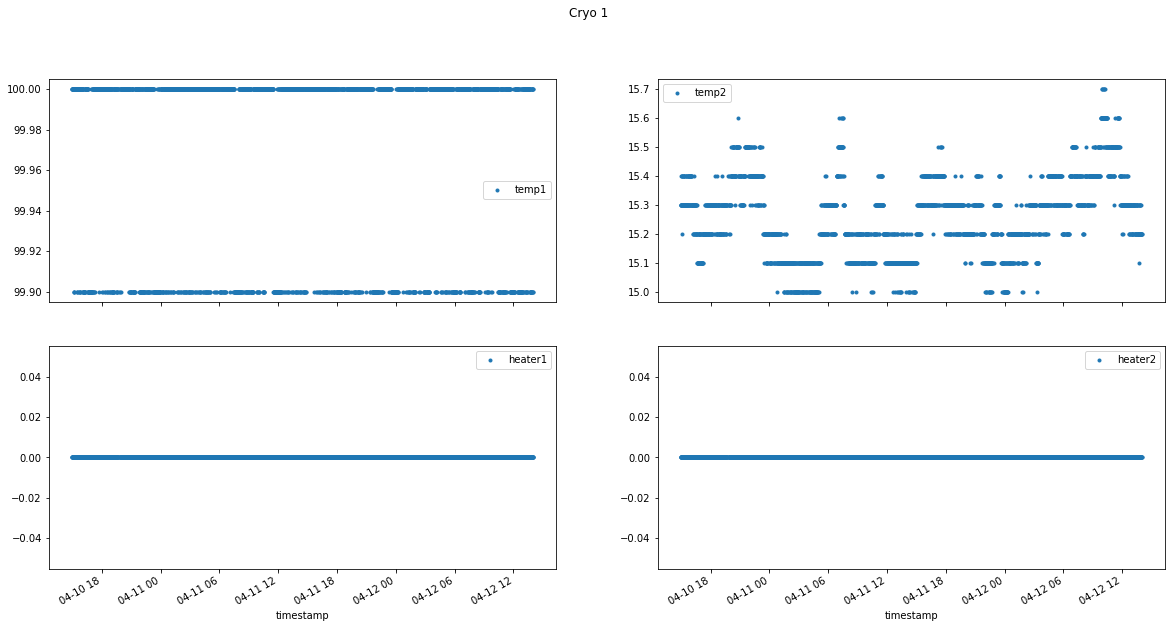

In [110]:
i_cryo = 1
unitsequence = get_unitsequences(x_cryo)[i_cryo]
x_pump = get_pump(x_cryo, unitsequence)
intervals = get_intervals(x_pump)
interval = intervals[0]
plot_interval(interval, cryo_vals[:4], title="Cryo {}".format(i_cryo))

### Let's try turbos.

There are 2 intervals


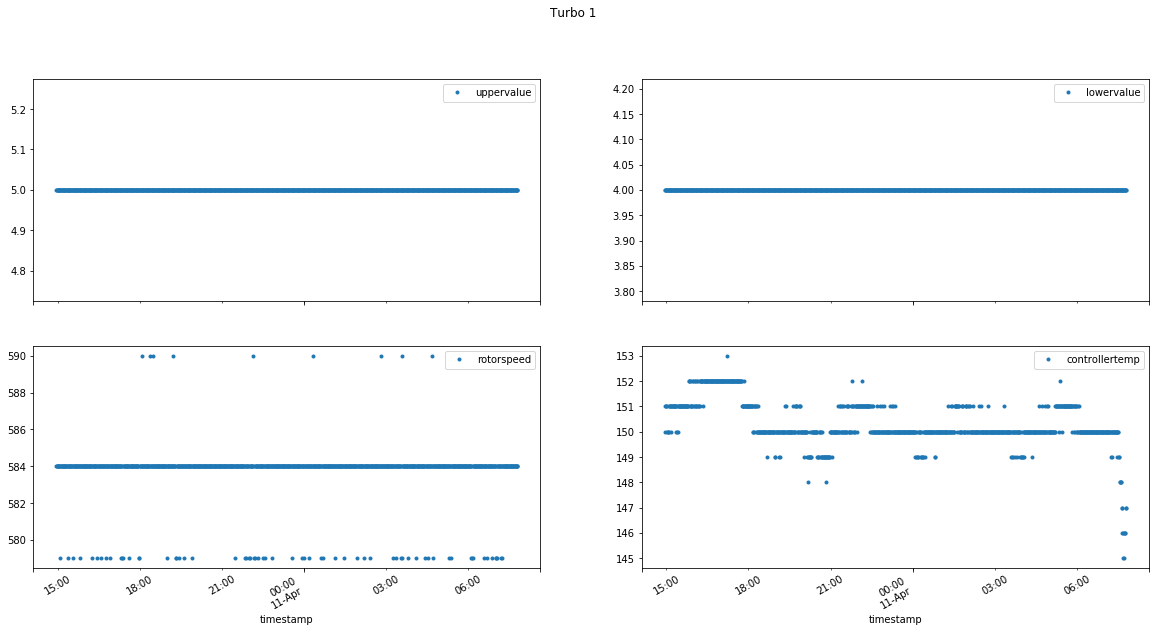

In [109]:
i_turbo = 1
unitsequence = get_unitsequences(x_turbo)[i_turbo]
x_pump = get_pump(x_turbo, unitsequence)
intervals = get_intervals(x_pump)
interval = intervals[0]
print("There are {} intervals".format(len(intervals)))
plot_interval(interval, turbo_vals[:4], title="Turbo {}".format(i_turbo))

## Big Picture
So far our results have been uninteresting.  
Let's pick the turbo pump that has the longest-running interval and analyze it.  
Try `unitsequence = 167757766`. This has `1,048,132` elements.  

So there are correlations going on, though they're extremely obvious. Motor speed corresponds with motor temperature - who knew? There's a lot of feature engineering to be done here, but the data is clean and ready.  

ms: (266806, 38)


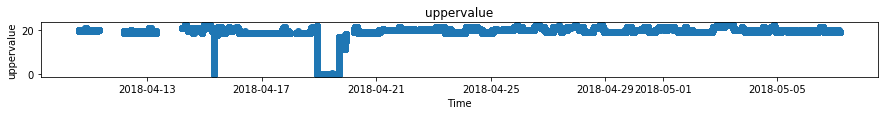

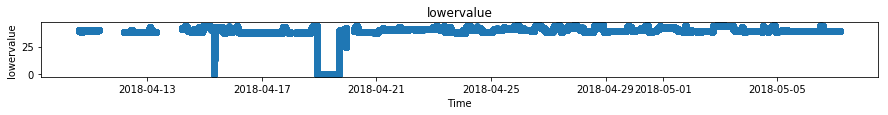

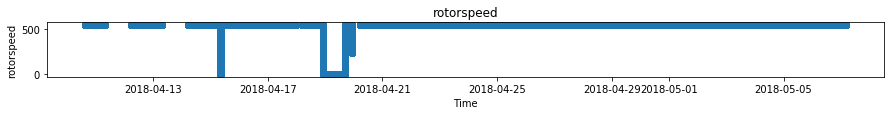

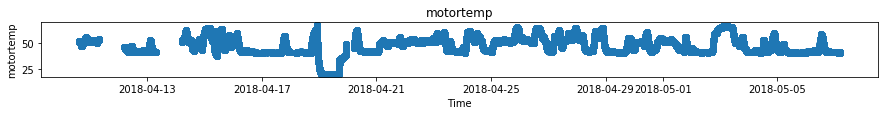

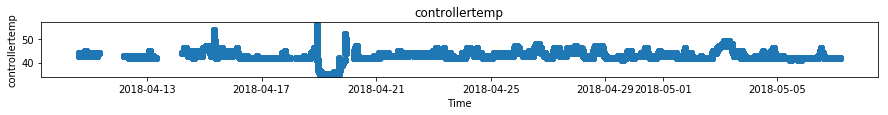

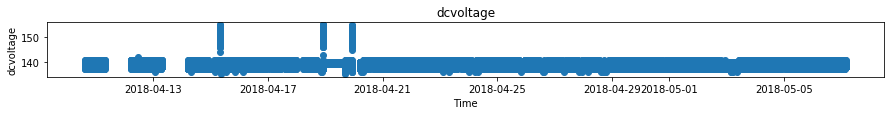

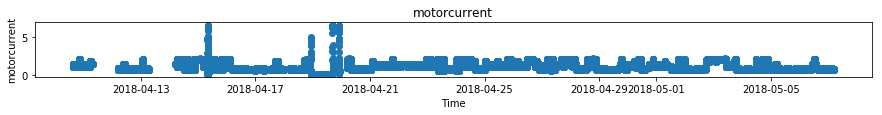

In [49]:
def plot_over_time(t,y,desc):
    fig = plt.figure(figsize=(15,1))
    ax = fig.add_subplot(111)
    ax.plot(t, y, 'o')
    ax.set_xlabel("Time")
    ax.set_ylabel(desc)
    ax.set_title(desc)
    plt.show()

def time_slice(m):
    dt1 = '2018-05-01 00:00:00'
#     dt2 = '2018-06-27 06:00:00'
    ms = m[(dt1 <= m['timestamp'])] #& (m['timestamp'] < dt2)]
    print("ms:", ms.shape)  
    return ms
    
n_timesteps, n_cols = m.shape
ms = time_slice(m)
t = m["timestamp"].values
cols = ["uppervalue", "lowervalue", "rotorspeed","motortemp","controllertemp","dcvoltage","motorcurrent"]
for col in cols:
    plot_over_time(t,m[col].values,col)

# ---------------------------------------------------------------
Below this point are personal notes/scratch code. Feel free to stop here.

## Extract Dense Time Clusters for a Single `unitsequence`

All the clusters for unit_sequence 16775766
No. Clusters: 5
First Cluster


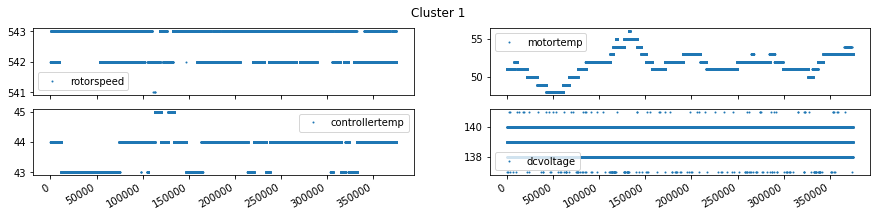

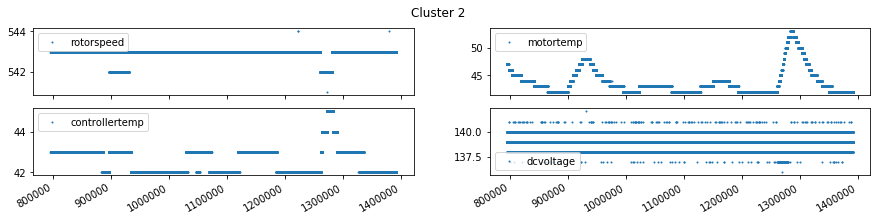

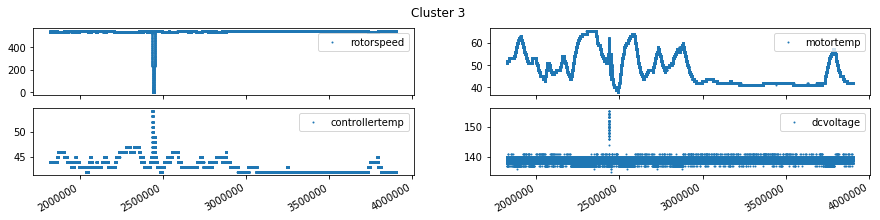

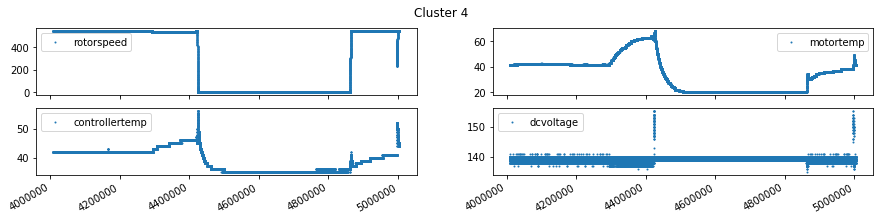

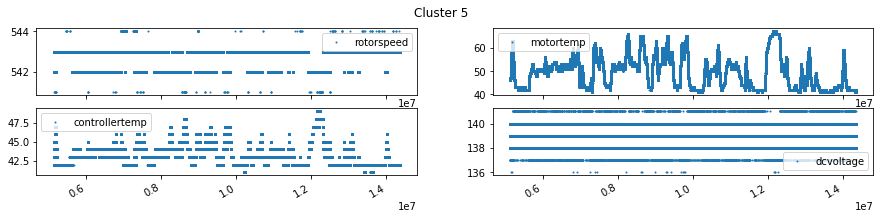

In [19]:
def get_clusters(unit_sequence_id):
    """
    Parameters:
        unit_sequence_id (int): the id of the pump (fx -18202).
        # col_name (str): the column to extract data for (fx "controllertemp")
    Returns:
        clusters (list(DataFrame)): the DataFrame clusters, ordered by time.
    """
    dfc = x[x["unitsequence"] == unit_sequence_id].sort_values("timestamp").copy()
    cluster = (dfc["timestamp"].diff() > pd.Timedelta(minutes=30)).cumsum()
    dfc = [v for k,v in dfc.groupby(cluster)]
    return dfc

def plot_cluster(cluster, title=None, col_names=["rotorspeed", "motortemp", "controllertemp", "dcvoltage"]):
    cluster.plot(y=col_names,
                subplots=True, layout=(2,2), marker='o', linestyle='None', color=blue,
                markersize=1)
    if title:
        plt.suptitle(title)
    plt.show()
    
def plot_cluster_magnets(cluster, title=None):
    magcurrents = ["magcurrent{}".format(i) for i in range(9)]
    cluster.plot(y=magcurrents,
                subplots=True, layout=(3,3), marker='o', linestyle='None', color=blue,
                markersize=1, figsize=(10,10))
    if title:
        plt.suptitle(title)
    plt.show()

clusters = get_clusters(us)
print("All the clusters for unit_sequence {}".format(us))
print("No. Clusters:", len(clusters))
print("First Cluster")
for i, cluster in enumerate(clusters):
    plot_cluster(cluster, title="Cluster {}".format(i+1))
#     plot_cluster(cluster, title="Cluster {}".format(i+1), col_names=["temp1", "temp2", "heater1", "heater2"])
#     if i == 1:
#         break

## Questions
Why aren't we seeing ramp-down speed?  
How do I plot dates, not just timesteps?  
Can I segment sections with only positive slope/negative slope?  
Does the OLS slope give information about pump health?  


## Notes
CRYO refers to cryogenic.  
SRU refers to turbo - [SRU Biosystems BIND Reader TURBO Plate Reader](https://www.labx.com/item/sru-biosystems-bind-reader-turbo-plate-reader/LV39187140).

Sample CRYO (us `17338484`) has `rotorspeed`, `temp1`, `temp2`, `heater1`, `heater2`, `tcpressure`, `timestamp`, `currentregen`.  
Sample SCU (us `16776830`) has `uppervalue`, `lowervalue`, `rotorspeed`, `controllertemp`, `dcvoltage`, `motorcurrent`, `timestamp`.  
Another sample CRYO (us `16775258`) is missing `rotorspeed`.  

Single `listenerid` for everything.  
Same `groupname` - IM1004.  

`motorspeed` is NaN for everything (even cryos), contrary to what TCS said.  
`rotospeed` is defined for cryos, though TCS said it's only turbo.  

`currentregen` is either `P` or `V` for cryos - what does this mean?  

## Data Cleaning
NaN values in `x_unit['outofservice']`.  
Evaluate only cryos, or only sru. Then we can get rid of NaN values.  
Subsample to the second.  
Merge into a single table, remove the NaNs, label with "Turbo" or "Cryo". 

## Planning Success
(from the *[Deep Learning Book](https://www.deeplearningbook.org/contents/guidelines.html)*)  
**Determine your goals. What error metric will you use? What target value for this error metric?**  
- Cluster similarity - given values, can we group clusters by pump?
- Predicting pump failure (but we don't have failure data!)
- 

**Establish a working end-to-end pipeline as soon as possible, including estimation of possible performance metrics.** 


**Instrument the system well to determine bottlenecks in performance. Determine which componenents are performing worse 
than expected, and whether the poor performance is due to underfitting, overfitting, or software defects.**  


**Repeatedly make incremental changes such as gathering new data, adjusting hyperparameters, or changing algorithms, based 
on specific findings from your instrumentation.**  

**Which features will I use?**  
- Correlation matrices (fx motor speed vs motor current), r-squared values.
- DTW distance.
- Slope of motor rampup/cooldown speed.

**Which algorithms will I use?**
- Decision Tree/Random Forest/XGBoost (not a clustering algorithm!)
- K-means on various feature subsets
- Hierarchical clustering
- Expectation Maximization on Gaussian Mixture Models
- Gaussian Process Regression